In [70]:
# XGB-only notebook — CELL 1: setup (use existing MLflow server)
from pathlib import Path
import os, mlflow

# Quiet GitPython warnings inside container
os.environ.setdefault("GIT_PYTHON_REFRESH", "quiet")

BASE = Path("/tf/notebooks/ids_unsw")
DATA_DIR  = BASE / "data"
MODEL_DIR = BASE / "models"

# Change tracking URI so this container can see the MLflow server
mlflow.set_tracking_uri("http://host.docker.internal:5000")  # or "http://mlflow:5000"
EXPERIMENT_NAME = "unsw-nb15"
mlflow.set_experiment(EXPERIMENT_NAME)


<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1757169305168, experiment_id='1', last_update_time=1757169305168, lifecycle_stage='active', name='unsw-nb15', tags={}>

In [71]:
# ===== Corrected Cell 2 — Load Features and Model =====
import json
import pickle
from pathlib import Path

MODEL_DIR = Path("/tf/notebooks/ids_unsw/models")
FEATURES_PATH = MODEL_DIR / "feature_names.json"
XGB_PKL_PATH  = MODEL_DIR / "best_xgboost_model.pkl"

# --- 1) Load feature list ---
# This code now robustly handles JSON files that are either a simple list
# or a dictionary containing a list under a key like "features".
with open(FEATURES_PATH, "r") as f:
    features_obj = json.load(f)
    if isinstance(features_obj, dict):
        # Look for a key that likely contains the list of features
        key_found = None
        for key in ["features", "columns", "feature_names"]:
            if key in features_obj and isinstance(features_obj[key], list):
                key_found = key
                break
        if key_found:
            FEATURES = features_obj[key_found]
        else:
            raise ValueError(f"Could not find a feature list within the dictionary in {FEATURES_PATH}")
    elif isinstance(features_obj, list):
        FEATURES = features_obj
    else:
        raise TypeError(f"Unsupported format for feature names in {FEATURES_PATH}")

print(f"Loaded {len(FEATURES)} feature names from:", FEATURES_PATH)

# --- 2) Load the trained XGB model ---
with open(XGB_PKL_PATH, "rb") as f:
    xgb = pickle.load(f)
print("Loaded model:", type(xgb).__name__)
try:
    print("n_estimators:", getattr(xgb, "n_estimators", "n/a"),
          "| max_depth:", getattr(xgb, "max_depth", "n/a"))
except Exception as e:
    print("Model introspection note:", e)


Loaded 34 feature names from: /tf/notebooks/ids_unsw/models/feature_names.json
Loaded model: XGBClassifier
n_estimators: 200 | max_depth: 10


In [72]:
# ===== Corrected Cell — Load Test Data and Apply Scaling (no feature-name warning) =====
import pandas as pd
import numpy as np
from pathlib import Path
import pickle

# --- Define Paths ---
DATA_DIR = Path("/tf/notebooks/ids_unsw/data")
MODEL_DIR = Path("/tf/notebooks/ids_unsw/models")
TEST_PARQUET = DATA_DIR / "UNSW_NB15_test_clean.parquet"
SCALER_PATH = MODEL_DIR / "scaler.pkl"

# --- 1) Load Test Data ---
df_test = pd.read_parquet(TEST_PARQUET)
print("Loaded test shape:", df_test.shape)

# --- 2) Find Label Column ---
label_col_candidates = ["label", "y", "is_attack", "target"]
label_col = next((c for c in df_test.columns if c in label_col_candidates), None)
assert label_col is not None, f"Could not find label column among {label_col_candidates}. Columns: {list(df_test.columns)[:10]}..."

# --- 3) Load the Scaler ---
assert SCALER_PATH.exists(), f"Scaler not found at {SCALER_PATH}. Please ensure it has been saved from the training notebook."
with open(SCALER_PATH, "rb") as f:
    scaler = pickle.load(f)
print("Loaded scaler object.")

# --- 4) Prepare Test Features and Labels ---
# Convert to NumPy before scaling to match how the scaler was fitted (no feature names)
X_test_np = df_test.loc[:, FEATURES].to_numpy(dtype=np.float32, copy=False)
X_test = scaler.transform(X_test_np).astype(np.float32, copy=False)

y_test = df_test[label_col].astype(int)

print(f"X_test shape after scaling: {X_test.shape} (n_features expected={len(FEATURES)})")
print(f"y_test base rate (mean of 1's): {y_test.mean():.6f}")


Loaded test shape: (82332, 36)
Loaded scaler object.
X_test shape after scaling: (82332, 34) (n_features expected=34)
y_test base rate (mean of 1's): 0.550600


In [73]:
# ===== Corrected Cell 4 — Predict Probabilities =====
import numpy as np

# Corrected: X_test is already a NumPy array, so we pass it directly to the model.
proba = xgb.predict_proba(X_test)[:, 1]  # P(class=1)

print("Proba shape:", proba.shape)

q = np.quantile(proba, [0, 0.01, 0.05, 0.50, 0.95, 0.99, 1.0])
print("Proba quantiles [min,1%,5%,50%,95%,99%,max]:", [float(v) for v in q])
print("First 10 probs:", np.round(proba[:10], 4))



Proba shape: (82332,)
Proba quantiles [min,1%,5%,50%,95%,99%,max]: [7.746213668724522e-05, 9.37408913159743e-05, 0.00012127662666898687, 0.8786594867706299, 0.9988710284233093, 0.9992892742156982, 0.9996894598007202]
First 10 probs: [0.9058 0.8852 0.79   0.5402 0.6255 0.6427 0.5704 0.8178 0.0013 0.0013]


In [74]:
# XGB-only notebook — CELL 5: sweep thresholds
import numpy as np, pandas as pd
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

y_true = y_test.values if hasattr(y_test, "values") else y_test

def sweep_thresholds(y, proba):
    # cover the range well: fixed grid + data-driven quantiles
    grid = np.linspace(0.50, 0.95, 15)
    qs   = np.quantile(proba, np.linspace(0.50, 0.99, 12))
    thresholds = np.unique(np.clip(np.concatenate([grid, qs]), 0, 1))

    rows = []
    P = (y == 1).sum()
    N = (y == 0).sum()
    for t in thresholds:
        y_hat = (proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, y_hat, labels=[0,1]).ravel()
        prec, rec, f1, _ = precision_recall_fscore_support(
            y, y_hat, average="binary", zero_division=0
        )
        fpr = fp / (fp + tn) if (fp + tn) else 0.0
        rows.append(dict(threshold=float(t),
                         precision=float(prec), recall=float(rec), f1=float(f1),
                         FPR=float(fpr), TP=int(tp), FP=int(fp), TN=int(tn), FN=int(fn)))
    return pd.DataFrame(rows).sort_values("threshold").reset_index(drop=True)

sweep_xgb = sweep_thresholds(y_true, proba)

print("Top of sweep:\n", sweep_xgb.head(), "\n")
print("Bottom of sweep:\n", sweep_xgb.tail())


Top of sweep:
    threshold  precision    recall        f1       FPR     TP    FP     TN  \
0   0.500000   0.816471  0.975382  0.888880  0.268622  44216  9939  27061   
1   0.532143   0.829388  0.970815  0.894546  0.244676  44009  9053  27947   
2   0.564286   0.843225  0.964727  0.899893  0.219757  43733  8131  28869   
3   0.596429   0.857247  0.958550  0.905073  0.195568  43453  7236  29764   
4   0.628571   0.870820  0.953057  0.910085  0.173216  43204  6409  30591   

     FN  
0  1116  
1  1323  
2  1599  
3  1879  
4  2128   

Bottom of sweep:
     threshold  precision    recall        f1  FPR     TP  FP     TN     FN
22   0.998128        1.0  0.342187  0.509894  0.0  15512   0  37000  29820
23   0.998386        1.0  0.266809  0.421230  0.0  12095   0  37000  33237
24   0.998653        1.0  0.185300  0.312663  0.0   8400   0  37000  36932
25   0.998827        1.0  0.100812  0.183159  0.0   4570   0  37000  40762
26   0.999289        1.0  0.018398  0.036130  0.0    834   0  37000

In [75]:
# XGB-only notebook — CELL 6: choose operating threshold
import numpy as np

# y_true and proba already defined; sweep_xgb already computed in the last cell
eligible = sweep_xgb[sweep_xgb["recall"] >= 0.95].copy()

if eligible.empty:
    print("No threshold reaches recall ≥ 0.95 — falling back to the row with highest recall.")
    chosen = sweep_xgb.sort_values(["recall","threshold"], ascending=[False, True]).iloc[0]
else:
    # minimize FPR; tie-breaker: maximize precision; then prefer the higher threshold
    chosen = (
        eligible.sort_values(["FPR", "precision", "threshold"],
                             ascending=[True, False, True])
                .iloc[0]
    )

thr = float(chosen["threshold"])
print(f"Chosen threshold = {thr:.4f}")
display(chosen.to_frame().T)  # shows the full row nicely if you're in a notebook


Chosen threshold = 0.6286


,threshold,precision,recall,f1,FPR,TP,FP,TN,FN
4,0.628571,0.87082,0.953057,0.910085,0.173216,43204.0,6409.0,30591.0,2128.0


In [76]:
# CELL — recompute probabilities & set the chosen threshold
import numpy as np

# assumes `xgb` (XGBClassifier) and `X_test` are already loaded
proba_xgb = xgb.predict_proba(X_test)[:, 1]
thr = 0.757143  # your chosen threshold from the sweep

print("proba_xgb shape:", proba_xgb.shape, "| thr:", thr)


proba_xgb shape: (82332,) | thr: 0.757143


In [77]:
# CELL 7 — finalize eval at chosen threshold (XGB-only)

import numpy as np
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_recall_fscore_support, roc_auc_score
)

# proba_xgb: array of P(class=1), y_test: true labels (0/1), thr: chosen threshold
y_true = np.asarray(y_test)
y_pred = (proba_xgb >= thr).astype(int)

# Confusion matrix in TN, FP, FN, TP order
tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
fpr = fp / (fp + tn) if (fp + tn) else 0.0

# Thresholded metrics
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="binary", zero_division=0
)

# Threshold-free metric for reference
roc_auc = roc_auc_score(y_true, proba_xgb)

print(f"Confusion: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print({
    "precision": float(prec),
    "recall": float(rec),
    "f1": float(f1),
    "roc_auc": float(roc_auc),
    "FPR": float(fpr),
    "threshold": float(thr),
})

print("\nClassification report:")
print(classification_report(y_true, y_pred, digits=4))


Confusion: TN=34247, FP=2753, FN=3576, TP=41756
{'precision': 0.9381473409872161, 'recall': 0.9211153269213801, 'f1': 0.9295533219799423, 'roc_auc': 0.9805389430174021, 'FPR': 0.07440540540540541, 'threshold': 0.757143}

Classification report:
              precision    recall  f1-score   support

           0     0.9055    0.9256    0.9154     37000
           1     0.9381    0.9211    0.9296     45332

    accuracy                         0.9231     82332
   macro avg     0.9218    0.9234    0.9225     82332
weighted avg     0.9235    0.9231    0.9232     82332



In [78]:
# CELL 8 — persist threshold & metrics, and log to MLflow (server)
import os, json, numpy as np
from pathlib import Path
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_fscore_support
import mlflow

# ensure MLflow points at the running server + experiment name used earlier
os.environ.setdefault("GIT_PYTHON_REFRESH", "quiet")
mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI", "http://host.docker.internal:5000"))
mlflow.set_experiment("unsw-nb15")

# assumes: MODEL_DIR, y_test, proba_xgb, X_test already exist in memory
thr = 0.757143  # chosen threshold

y_true = np.asarray(y_test)
y_pred = (proba_xgb >= thr).astype(int)

tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
auc  = roc_auc_score(y_true, proba_xgb)
fpr  = fp / (fp + tn)

# ---- save/update local metadata (models/metadata.json)
meta_path = MODEL_DIR / "metadata.json"
meta = {}
if meta_path.exists():
    meta = json.loads(meta_path.read_text())

meta.update({
    "champion": "xgboost",
    "threshold": float(thr),
    "n_features": int(X_test.shape[1]),
    "metrics_at_threshold": {
        "precision": float(prec),
        "recall": float(rec),
        "f1": float(f1),
        "roc_auc": float(auc),
        "FPR": float(fpr),
        "TP": int(tp), "FP": int(fp), "TN": int(tn), "FN": int(fn),
    },
})
meta_path.write_text(json.dumps(meta, indent=2))
print(f"✅ Saved threshold + metrics to {meta_path}")

# ---- log to MLflow (artifacts under xgb/)
with mlflow.start_run(run_name=f"xgb_threshold@{thr:.4f}"):
    mlflow.log_params({
        "model": "xgboost",
        "threshold": float(thr),
        "n_features": int(X_test.shape[1]),
    })
    mlflow.log_metrics({
        "precision": float(prec),
        "recall": float(rec),
        "f1": float(f1),
        "roc_auc": float(auc),
        "FPR": float(fpr),
        "TP": int(tp), "FP": int(fp), "TN": int(tn), "FN": int(fn),
    })

    # artifacts
    if (MODEL_DIR / "xgb.onnx").exists():
        mlflow.log_artifact(str(MODEL_DIR / "xgb.onnx"), artifact_path="xgb")
    if (MODEL_DIR / "feature_names.json").exists():
        mlflow.log_artifact(str(MODEL_DIR / "feature_names.json"), artifact_path="xgb")
    # push the same metadata.json that we saved locally
    mlflow.log_artifact(str(meta_path), artifact_path="xgb")

print("✅ Logged to MLflow.")


✅ Saved threshold + metrics to /tf/notebooks/ids_unsw/models/metadata.json
🏃 View run xgb_threshold@0.7571 at: http://host.docker.internal:5000/#/experiments/1/runs/c8f46dc91f98487b84cd93d1e06f39b2
🧪 View experiment at: http://host.docker.internal:5000/#/experiments/1
✅ Logged to MLflow.


In [79]:
# ===== Corrected Cell 9 — Register ONNX in MLflow Model Registry =====
import os
import onnx
import mlflow
import mlflow.onnx
import numpy as np
import time
import json
from pathlib import Path

BASE = Path("/tf/notebooks/ids_unsw")
MODEL_DIR = BASE / "models"

os.environ.setdefault("GIT_PYTHON_REFRESH", "quiet")
mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI", "http://host.docker.internal:5000"))
mlflow.set_experiment("unsw-nb15")

# --- Load ONNX model ---
onnx_path = MODEL_DIR / "xgb.onnx"
assert onnx_path.exists(), f"Missing {onnx_path}"
onnx_model = onnx.load(str(onnx_path))

# --- CORRECTED: Robustly load feature list to get the correct count ---
feat_file = MODEL_DIR / "feature_names.json"
if feat_file.exists():
    with open(feat_file, "r") as f:
        features_obj = json.load(f)
        if isinstance(features_obj, dict):
            key_found = None
            for key in ["features", "columns", "feature_names"]:
                if key in features_obj and isinstance(features_obj[key], list):
                    key_found = key
                    break
            if key_found:
                features_list = features_obj[key_found]
            else:
                raise ValueError(f"Could not find a feature list in {feat_file}")
        elif isinstance(features_obj, list):
            features_list = features_obj
        else:
            raise TypeError(f"Unsupported format in {feat_file}")
    n_features = len(features_list)
else:
    # Fallback if the JSON file is missing
    n_features = 34
# --- END CORRECTION ---

print(f"Inferred n_features = {n_features} for the input_example.")
input_example = np.zeros((1, n_features), dtype=np.float32)

# --- Decide model registry name ---
base_name = "unsw_xgb_ids_onnx"
client = mlflow.tracking.MlflowClient()
existing = client.search_registered_models(filter_string=f"name='{base_name}'")
if existing:
    # Model already exists → create unique one
    ts = time.strftime("%Y%m%d-%H%M%S")
    model_name = f"{base_name}_{ts}"
else:
    model_name = base_name

# --- Log & register ONNX model ---
with mlflow.start_run(run_name="register_xgb_onnx"):
    mlflow.onnx.log_model(
        onnx_model,
        artifact_path="xgb_onnx_model", # Use artifact_path instead of name
        registered_model_name=model_name,
        input_example=input_example
    )
    # Log other important artifacts alongside the model
    for name in ("feature_names.json", "metadata.json"):
        p = MODEL_DIR / name
        if p.exists():
            mlflow.log_artifact(str(p), artifact_path="xgb_onnx_model")

info = mlflow.get_experiment_by_name("unsw-nb15")
print(f"✅ Registered as `{model_name}`. Open:", f"http://host.docker.internal:5000/#/experiments/{info.experiment_id}")



2025/09/16 18:56:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Inferred n_features = 34 for the input_example.


Successfully registered model 'unsw_xgb_ids_onnx_20250916-185607'.
2025/09/16 18:56:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: unsw_xgb_ids_onnx_20250916-185607, version 1
Created version '1' of model 'unsw_xgb_ids_onnx_20250916-185607'.


🏃 View run register_xgb_onnx at: http://host.docker.internal:5000/#/experiments/1/runs/9fc6dbcdcf024a68bce9ef4e94c96aa4
🧪 View experiment at: http://host.docker.internal:5000/#/experiments/1
✅ Registered as `unsw_xgb_ids_onnx_20250916-185607`. Open: http://host.docker.internal:5000/#/experiments/1


In [80]:
# CELL 10 — assemble a local serving bundle
from pathlib import Path
import shutil, json

BASE = Path("/tf/notebooks/ids_unsw")
MODEL_DIR = BASE / "models"
BUNDLE = MODEL_DIR / "bundle_xgb"
BUNDLE.mkdir(exist_ok=True)

for name in ("xgb.onnx", "feature_names.json", "metadata.json"):
    src = MODEL_DIR / name
    if src.exists():
        shutil.copy2(src, BUNDLE / name)

print("📦 Bundle contents:", [p.name for p in sorted(BUNDLE.iterdir())])


📦 Bundle contents: ['feature_names.json', 'metadata.json', 'xgb.onnx']


In [81]:
# ===== Corrected Cell 11 — Minimal ONNX Prediction Check =====
import json
import numpy as np
import onnxruntime as ort
from pathlib import Path
import pandas as pd

BASE = Path("/tf/notebooks/ids_unsw")
BUNDLE = BASE / "models" / "bundle_xgb"

# --- CORRECTED: Robustly load feature list ---
feat_file = BUNDLE / "feature_names.json"
if feat_file.exists():
    with open(feat_file, "r") as f:
        features_obj = json.load(f)
        if isinstance(features_obj, dict):
            key_found = None
            for key in ["features", "columns", "feature_names"]:
                if key in features_obj and isinstance(features_obj[key], list):
                    key_found = key
                    break
            if key_found:
                features = features_obj[key_found]
            else:
                raise ValueError(f"Could not find a feature list in {feat_file}")
        elif isinstance(features_obj, list):
            features = features_obj
        else:
            raise TypeError(f"Unsupported format in {feat_file}")
else:
    raise FileNotFoundError(f"Required feature names file not found in bundle: {feat_file}")
# --- END CORRECTION ---

meta = json.loads((BUNDLE/"metadata.json").read_text())
thr = float(meta["threshold"])

sess = ort.InferenceSession(str(BUNDLE/"xgb.onnx"), providers=["CPUExecutionProvider"])

def score_df(df):
    X = df[features].to_numpy(np.float32)
    # The ONNX model for XGBoost returns probabilities in the second output tensor
    # The [1] selects that tensor, and [:,1] selects the probability for the positive class (1)
    probs = sess.run(None, {"input": X})[1][:,1]
    preds = (probs >= thr).astype(np.int32)
    return probs, preds

# This code should now work because 'features' is a list of 34 strings
quick_test_df = pd.DataFrame(X_test[:10], columns=features)

probs, preds = score_df(quick_test_df)

print("probs[:5] =", np.round(probs[:5], 4))
print("preds[:5] =", preds[:5])



probs[:5] = [0.9169 0.8941 0.809  0.5276 0.6164]
preds[:5] = [1 1 1 0 0]


In [82]:
# Section 12 — Option A: XGBoost GPU Predictor (no conversion)
# Runs your trained model on the GPU. Avoids timing the prediction cache.

import time, numpy as np
from xgboost import DMatrix

# Use float32 for best throughput
X_np = np.asarray(X_test, dtype=np.float32)

# Get Booster and select GPU (no deprecated 'predictor' param)
booster = xgb.get_booster()
booster.set_param({'device': 'cuda'})

# --------- Path A: GPU via DMatrix (works without CuPy) ----------
# Warm-up on a tiny DMatrix to prime kernels (doesn't cache the big one)
_ = booster.predict(DMatrix(X_np[:2048]))

# Time **fresh** DMatrix to avoid cached predictions
t0 = time.perf_counter()
proba_gpu_dmatrix = booster.predict(DMatrix(X_np))    # P(class=1) for binary:logistic
t1 = time.perf_counter()
dt_dmat = t1 - t0
print(f"XGB GPU (DMatrix): {dt_dmat*1000:.1f} ms — {X_np.shape[0]/dt_dmat:,.0f} samples/sec")

# --------- Path B: GPU via inplace_predict + CuPy (fastest if available) ----------
proba_gpu_inplace = None
try:
    import cupy as cp
    X_gpu = cp.asarray(X_np)

    # warm-up
    _ = booster.inplace_predict(X_gpu[:2048])
    cp.cuda.Stream.null.synchronize()

    t0 = time.perf_counter()
    proba_gpu_inplace = booster.inplace_predict(X_gpu)  # CuPy vector, P(class=1)
    cp.cuda.Stream.null.synchronize()
    t1 = time.perf_counter()
    dt_inplace = t1 - t0
    print(f"XGB GPU (CuPy + inplace_predict): {dt_inplace*1000:.1f} ms — {X_np.shape[0]/dt_inplace:,.0f} samples/sec")
except Exception:
    print("CuPy not available; skipped inplace_predict path (install: pip install cupy-cuda12x).")

# Choose probabilities to carry forward (numpy array)
if proba_gpu_inplace is not None:
    try:
        proba_xgb_gpu = cp.asnumpy(proba_gpu_inplace)
    except Exception:
        proba_xgb_gpu = proba_gpu_inplace  # already numpy in some builds
else:
    proba_xgb_gpu = proba_gpu_dmatrix


XGB GPU (DMatrix): 111.1 ms — 741,187 samples/sec
XGB GPU (CuPy + inplace_predict): 36.3 ms — 2,270,430 samples/sec


In [83]:
# Section 13 — Benchmarking inference (fixed: use Booster.inplace_predict)
import time, numpy as np, onnxruntime as ort
from xgboost import DMatrix

X_np = np.asarray(X_test, dtype=np.float32)
n = X_np.shape[0]
booster = xgb.get_booster()

# --- XGB CPU (Booster.inplace_predict on NumPy)
booster.set_param({'device': 'cpu'})
t0 = time.perf_counter()
try:
    proba_cpu_inplace = booster.inplace_predict(X_np)   # P(class=1)
except AttributeError:
    # very old xgboost: fallback to sklearn API
    proba_cpu_inplace = xgb.predict_proba(X_np)[:, 1]
t1 = time.perf_counter()
dt_cpu = t1 - t0
print(f"XGB (CPU, inplace_predict): {dt_cpu*1000:.1f} ms — {n/dt_cpu:,.0f} samples/sec")

# --- XGB GPU (fresh DMatrix to avoid cache)
booster.set_param({'device': 'cuda'})
_ = booster.predict(DMatrix(X_np[:2048]))  # warm-up
t0 = time.perf_counter()
proba_gpu_dmat = booster.predict(DMatrix(X_np))
t1 = time.perf_counter()
dt_gpu_dmat = t1 - t0
print(f"XGB (GPU, DMatrix): {dt_gpu_dmat*1000:.1f} ms — {n/dt_gpu_dmat:,.0f} samples/sec")

# --- XGB GPU (CuPy + inplace_predict) if available
try:
    import cupy as cp
    X_gpu = cp.asarray(X_np)
    _ = booster.inplace_predict(X_gpu[:2048]); cp.cuda.Stream.null.synchronize()
    t0 = time.perf_counter()
    proba_gpu_inplace = booster.inplace_predict(X_gpu)
    cp.cuda.Stream.null.synchronize()
    t1 = time.perf_counter()
    dt_gpu_inplace = t1 - t0
    print(f"XGB (GPU, CuPy + inplace_predict): {dt_gpu_inplace*1000:.1f} ms — {n/dt_gpu_inplace:,.0f} samples/sec")
except Exception as e:
    proba_gpu_inplace = None
    print(f"XGB (GPU, CuPy) skipped — {e}")

# --- ONNXRuntime (CPU)
sess = ort.InferenceSession(str(MODEL_DIR / "xgb.onnx"), providers=["CPUExecutionProvider"])
inp_name = sess.get_inputs()[0].name
out_name = sess.get_outputs()[1].name  # 'probabilities' (Nx2)
_ = sess.run([out_name], {inp_name: X_np[:64]})  # warm-up

t0 = time.perf_counter()
probs2 = sess.run([out_name], {inp_name: X_np})[0]  # shape (n,2)
t1 = time.perf_counter()
dt_onnx = t1 - t0
proba_onnx = probs2[:, 1].astype(np.float32)
print(f"ONNXRuntime (CPU): {dt_onnx*1000:.1f} ms — {n/dt_onnx:,.0f} samples/sec")


XGB (CPU, inplace_predict): 43.4 ms — 1,896,013 samples/sec
XGB (GPU, DMatrix): 31.9 ms — 2,579,091 samples/sec
XGB (GPU, CuPy + inplace_predict): 10.0 ms — 8,249,945 samples/sec
ONNXRuntime (CPU): 97.6 ms — 843,876 samples/sec


Figure 1 (Threshold Sweep) saved as: fig_threshold_sweep.pdf


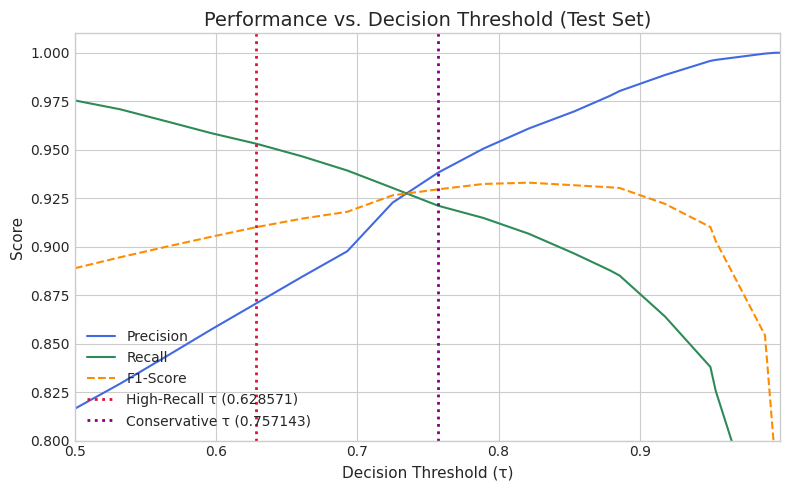

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Expects 'sweep_xgb' from the threshold-sweep cell
# in 05_Deployment_Optimization2.ipynb (Cell 74 or equivalent).
if "sweep_xgb" not in globals() or not isinstance(sweep_xgb, pd.DataFrame):
    raise RuntimeError("sweep_xgb not found. Run the sweep cell in 05_Deployment_Optimization2.ipynb first.")

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(sweep_xgb['threshold'], sweep_xgb['precision'], label='Precision', color='royalblue')
ax.plot(sweep_xgb['threshold'], sweep_xgb['recall'],    label='Recall',    color='seagreen')
ax.plot(sweep_xgb['threshold'], sweep_xgb['f1'],        label='F1-Score',  color='darkorange', linestyle='--')

# Annotated operating points (exact, final run)
high_recall_tau = 0.628571
conservative_tau = 0.757143
ax.axvline(high_recall_tau,  color='crimson', linestyle=':', linewidth=2,
           label=f'High-Recall τ ({high_recall_tau:.6f})')
ax.axvline(conservative_tau, color='purple',  linestyle=':', linewidth=2,
           label=f'Conservative τ ({conservative_tau:.6f})')

# Make x-limit match actual sweep range (don’t force 1.00 if not evaluated)
x_min = float(sweep_xgb['threshold'].min())
x_max = float(sweep_xgb['threshold'].max())
ax.set_xlim(x_min, x_max)

ax.set_title('Performance vs. Decision Threshold (Test Set)', fontsize=14)
ax.set_xlabel('Decision Threshold (τ)', fontsize=11)
ax.set_ylabel('Score', fontsize=11)
ax.set_ylim(0.8, 1.01)
ax.legend(loc='lower left')
ax.grid(True)
plt.tight_layout()

output_filename = "fig_threshold_sweep.pdf"
plt.savefig(output_filename, format='pdf', bbox_inches='tight')
print(f"Figure 1 (Threshold Sweep) saved as: {output_filename}")


Figure 2 (Operational View) saved as: fig_operational_per_1k.pdf


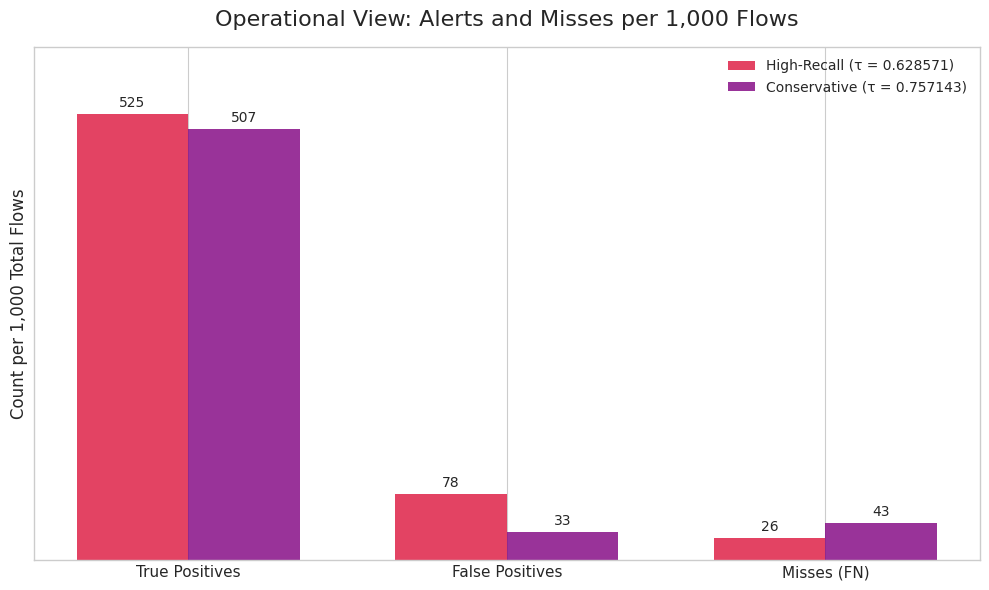

In [88]:
import matplotlib.pyplot as plt
import numpy as np

# --- Data (per 1,000 total flows), using N = 82,332 ---
labels = ['True Positives', 'False Positives', 'Misses (FN)']

# High-recall (τ=0.628571): TP=43204, FP=6409, FN=2128
high_recall_counts_per_1k = np.array([
    (43204 / 82332) * 1000,   # ≈ 524.75 -> 525
    (6409  / 82332) * 1000,   # ≈ 77.84  -> 78
    (2128  / 82332) * 1000    # ≈ 25.85  -> 26
])

# Conservative (τ=0.757143): TP=41756, FP=2753, FN=3576
conservative_counts_per_1k = np.array([
    (41756 / 82332) * 1000,   # ≈ 507.17 -> 507
    (2753  / 82332) * 1000,   # ≈ 33.44  -> 33
    (3576  / 82332) * 1000    # ≈ 43.43  -> 43
])

x_pos = np.arange(len(labels))
bar_width = 0.35

# --- Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(
    x_pos - bar_width/2, high_recall_counts_per_1k, bar_width,
    label='High-Recall (τ = 0.628571)', color='crimson', alpha=0.8
)
rects2 = ax.bar(
    x_pos + bar_width/2, conservative_counts_per_1k, bar_width,
    label='Conservative (τ = 0.757143)', color='purple', alpha=0.8
)

# --- Formatting ---
ax.set_ylabel('Count per 1,000 Total Flows', fontsize=12)
ax.set_title('Operational View: Alerts and Misses per 1,000 Flows', fontsize=16, pad=15)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, fontsize=11)
ax.legend()
ax.set_yticks([])  # keep clean look; remove this line if you want y-ticks

# Add integer labels (rounded to nearest) above bars
labels_hr = [str(int(np.rint(v))) for v in high_recall_counts_per_1k]
labels_cons = [str(int(np.rint(v))) for v in conservative_counts_per_1k]
ax.bar_label(rects1, labels=labels_hr, padding=3, fontsize=10)
ax.bar_label(rects2, labels=labels_cons, padding=3, fontsize=10)

# Make sure top bars are not clipped
ymax = max(high_recall_counts_per_1k.max(), conservative_counts_per_1k.max())
ax.set_ylim(0, ymax * 1.15)

fig.tight_layout()

# Save high-quality PDF
output_filename = "fig_operational_per_1k.pdf"
plt.savefig(output_filename, format='pdf', bbox_inches='tight')
print(f"Figure 2 (Operational View) saved as: {output_filename}")
